- Limpiar la data de valores nulos
- Ver si podemos aplicar el target encoding (y resumir más la dummies)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as no
import seaborn as sns
import missingno as msno #Para graficar mis nulos
import gc
import warnings

warnings.filterwarnings('ignore') #Para que no me salgan caveats
gc.collect() #Como garbage cleaner
df = pd.read_csv('data_pseudo_limpia2.csv')
pd.set_option('display.max_columns',None) #Para ver todas mis columnas...

In [26]:
#Eliminaré las variables que no tienen data en sí.
df.drop(['EsCondominio'], inplace = True, axis=1)
df.drop(['NoTieneAlgunDatoExtra'],inplace=True,axis=1)
df.drop(['Area_Terreno'],inplace=True,axis=1)

In [27]:
cols = df.columns
print(*cols)

Unnamed: 0 Antiguedad Anunciante Balneario NroBanios Nro_pisos Cocheras Descripcion Direccion Disposicion Dormitorios Estado de Inmueble Fecha_pub Fila Fondo Frente Luminosidad Mantenimiento Mascotas Medidas Pisos_construibles TipoPuertaCochera Precio Referencia Tipo TipoCochera Ubicacion SinNombre Urbaniz Uso_comercial Uso_profesional Area_constr Area_total Area_constr_m2 Area_total_m2 Area_Terreno_m2 match 'Comedor' 'anx81tico' 'Deposito' 'Banio de servicio' 'Banio independiente' 'Patio' 'Sala' 'Banio de visitas' 'Escritorio' 'Balcon' 'Comedor diario' 'Kitchenette' 'Terraza' 'Sotano' 'Jardanxadn Interno' 'Cocina' 'Sala de estar' 'Lavanderanxada' 'Closet' 'Walking Closet' 'Cuarto de servicio' 'Conexion a gas' 'Guardiananxada' 'Luz' 'Sistema de seguridad' 'Agua' 'Internet' 'Servicio de Limpieza' 'Telefono' 'Cable' 'Areade sauna' 'Club House' 'anx81reas verdes' 'Piscina' 'Guarderanxada' 'Parque interno' 'Areade BBQ' 'Gimnasio' 'Solarium' 'Hall de ingreso' 'Areadeportiva' 'Jardanxadn' 'J

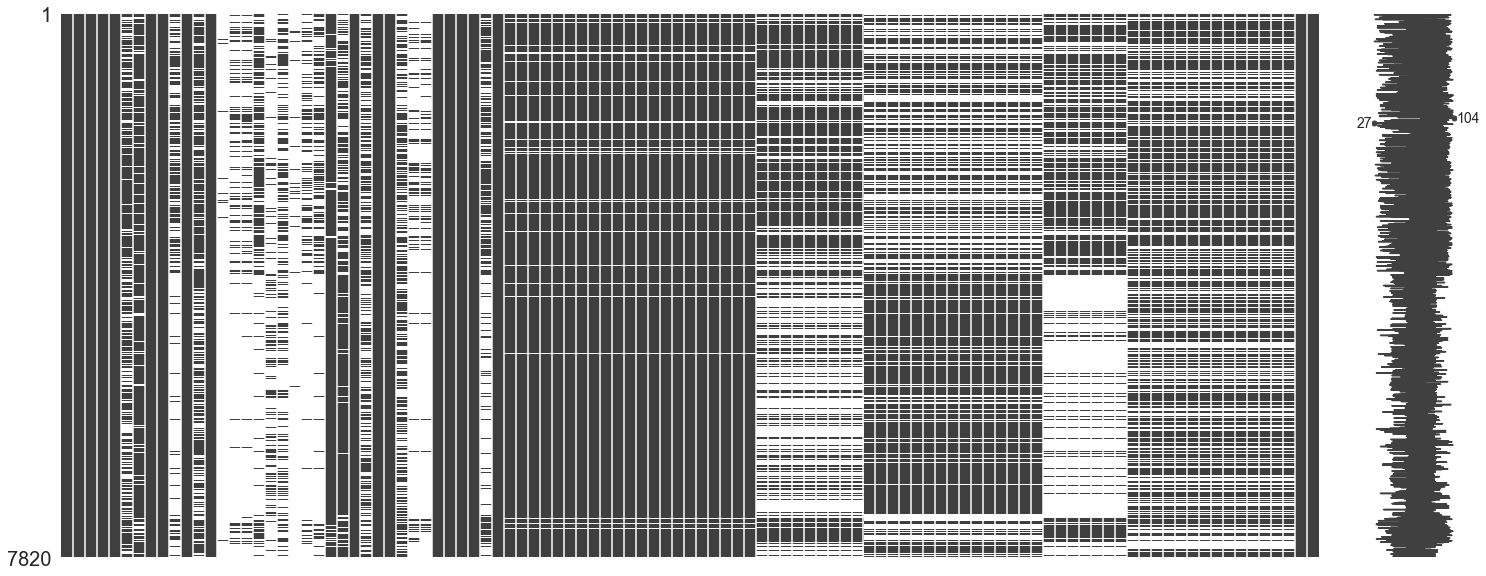

In [103]:
sns.set(style='whitegrid')
msno.matrix(df)

La variable "Balneario" nos dice en qué balneario está nuestra CASA DE PLAYA. Por lo tanto, revisaré si es que todas las casas de Playa tienen esta variable. Sino, reemplazo esos nulos por un "NoEspecifica". Y las casas normales las cambiaré por "NoEsCasaPlaya"  

In [29]:
#Reemplazo los valores nulos de Balneario
df.loc[(df['Balneario'].isna()) & (df['Tipo'] == 'Casa de Playa'),'Balneario'] = 'NoEspecifica'
df.loc[(df['Balneario'].isna()),'Balneario'] = 'Nulo'

Como algunos datos faltantes pueden encontrarse dentro de 'Descripcion', procederemos a standarizar todo descripción y buscar dentro de ella. Para eso, tendremos que reemplazar los valores que no son utf-8 y, a su vez, poner todo en letras minúsculas.

In [30]:
#PODEMOS BUSCAR LA INFO QUE NO ENCONTREMOS DENTRO DE DESCRIPCION
df['Descripcion'] = df['Descripcion'].str.lower() #Convierto todos los strings de la columna en minúsuculas.

In [31]:
o = df[df['Descripcion'].str.contains(' anios')]
o['Antiguedad'].isna() #Como solo hay 94 datos que se pueden reemplazar. Por ahora solo haré el reemplazo dsde la media.

#Reemplazaré Antiguedad por su media.

#OJO, hay casas MAS antiguas que no necesariamente tienen esta edad

##ESta no puede ser la solución más optima, pero opto por hacerla por fines prácticos.
df['Antiguedad'].fillna(int(df.Antiguedad.mean()),inplace=True)

In [32]:
##Nos encargaremos del nro de Banios. LLenaremos con la moda los valores nulos
#sns.countplot(x='NroBanios',data=df)
print(df['NroBanios'].isna().sum())
df['NroBanios'].fillna(5.0,inplace=True)

229


In [33]:
#Hay 3236 nulos en la var Nro_pisos, entonces veremos.
#Tenemos outliers, numero 33 y 44. así como 28... Los explorare,os
df[df['Nro_pisos'] == 33] #Dato erroneo, quiso decir 3 pisos
df[df['Nro_pisos'] == 44] #Dato erroneo, quiso decir 4 pisos
df[df['Nro_pisos'] == 28] #Dato erroneo, quiso decir 2 pisos
dict_r_pisos = {33:3,44:3,28:2}
for word,replace in dict_r_pisos.items():
    df['Nro_pisos'] = df['Nro_pisos'].replace(word,replace)

In [34]:
df[df['Nro_pisos'] == 8] #El de index 4671 sí tiene 8 pisos, mientras que el 6705 tiene 4. 
df.loc[df['Unnamed: 0'] == 7200, 'Nro_pisos'] = 4 #Reemplazo el valor

In [35]:
#Voy a reemplazar Disposición como esquina, buscando dentro de la descripción tal palabra. 
df.loc[(df['Descripcion'].str.contains('esquina')) & (df['Disposicion'].isna()),'Disposicion'] = 'Esquina' #Lista de columnas a reemplazar

###### Antes de continuar reemplazando los valores nulos, quisiera definir bien qué es lo que entiendo por las diferentes variables que hay
###### dentro de este dataset. Específicamente en Area_Terreno_m2, Area_constr_m2 y Area_total_m2.  Su diferencia y posible uso.

Area_Terreno_m2: Sería exactamente el área del terreno que se vende. Puede ser menor que el Area total y el Area Construida.

Area_constr_m2: Es el Area construida, depende del número de pisos que tenga la edificación.

Area_total_m2: Es el area construida mas el area que no se ha contado en la construccion, es decir, si tenemos una casa con
               
               2pisos y 1patio,entonces el Area_total_m2 será la suma del area del patio + area del piso 1 + area del piso2


In [36]:
#Acá estoy asumiendo que las casas con un solo piso, tienen la misma area de terreno y area total. Por lo tanto, reemplazo
#los valores nulos de Area_Terreno_m2 de esa forma. 
df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_Terreno_m2'] = df.loc[(df['Nro_pisos'] == 1) & (df['Area_Terreno_m2'].isna()),'Area_total_m2']

#Asimismo, reemplazaré los que tienen Area_total y Area_terreno igual como si fueran de un piso en los nulos de Nro_pisos


In [37]:
prueba = df[['Area_Terreno_m2','Area_constr_m2','Area_total_m2','Nro_pisos']]
print(prueba.Area_Terreno_m2.isna().sum())
print(prueba.Area_constr_m2.isna().sum())
print(prueba.Area_total_m2.isna().sum())

4546
8
6


#### Se ha optado por reemplazar los valores nulos de nro de pisos buscando dentro de la Descripción cuántos pisos hay

In [102]:
#df.groupby('Anunciante').count().sort_values(['Unnamed: 0','Nro_pisos'],ascending=False) #Para ver qué empresas ponen más nulos

#Primero veremos cuántos casos hay dentro de esta solución (¿Cuántos problemas no solucionaría?)
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
df[((df['Descripcion'].str.contains('|'.join(buscar_pisos))) & (df['Nro_pisos'].isna()))]

,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Comedor','anx81tico','Deposito','Banio de servicio','Banio independiente','Patio','Sala','Banio de visitas','Escritorio','Balcon','Comedor diario','Kitchenette','Terraza','Sotano','Jardanxadn Interno','Cocina','Sala de estar','Lavanderanxada','Closet','Walking Closet','Cuarto de servicio','Conexion a gas','Guardiananxada','Luz','Sistema de seguridad','Agua','Internet','Servicio de Limpieza','Telefono','Cable','Areade sauna','Club House','anx81reas verdes','Piscina','Guarderanxada','Parque interno','Areade BBQ','Gimnasio','Solarium','Hall de ingreso','Areadeportiva','Jardanxadn','Juegos para ninios','Sala de cine','Sala de internet','Cerca al mar','Ingreso independiente','Colegios cercanos','Frente al mar','Centros comerciales cercanos','Parques cercanos','Acceso personas discapacidad','Desagaue','Jacuzzi','Amoblado','Aire acondicionado','Chimenea','Calefaccion','Parrilla','Sauna','Cerco Electrico','Equipado','Portero electrico','Terma','Cocina con reposteros','Intercomunicador',Distrito,Provincia
14,16,3.0,BAQUERIZO CORREA PATRICIA,Nulo,5.0,NaN,NaN,excelente ubicacion! 903 m2. se vende casa en...,"Av. Grau, A Una Cuadra Del Parque Infantil De ...",NaN,5+,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa,NaN,Piura-Piura,Casa1011,NaN,NaN,NaN,874.14 m2,903.00 m2,874.0,903.0,465.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Piura,Piura
16,19,2.0,Lima Corretaje SAC,Punta Negra,2.0,NaN,NaN,"casa en punta negra, al frente del club soci...",Frente Al Club Social Y Deportes De Punta Negr...,NaN,4,Muy bueno,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,Si,NaN,NaN,NaN,158000.0,Frente al club social y deportes de Punta Negr...,Casa de Playa,NaN,PuntaNegra-Lima,Casa1014,NaN,NaN,NaN,132.00 m2,132.00 m2,132.0,132.0,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PuntaNegra,Lima
22,25,3.0,INMOBILIARIO PERÃ,Nulo,5.0,NaN,2.0,contacto : 9.8.6.9.7.6.1.2.4 venta de casa en...,Calle San Juan Xxx Ma Venta De Linda Casa A Un...,NaN,5+,A Remodelar,Publicado el 24.08.19,NaN,NaN,NaN,Muy luminoso,NaN,Si,NaN,NaN,AutomÃ¡tico,320000.0,A UNA CUADRA DEL OVALO HUAROCHIRI,Casa,Paralelas,LaMolina-Lima,Casa102,NaN,NaN,NaN,213.00 m2,244.00 m2,213.0,244.0,160.0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LaMolina,Lima
29,32,3.0,No disponible,Nulo,4.0,NaN,NaN,en la mejor zona de pachacamac. vecindario mu...,"Av. Jatosisa - Urb. San Fernando Pachacamac, L...",NaN,4,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100000.0,NaN,Casa de campo,NaN,Pachacamac-Lima,Casa1026,NaN,NaN,NaN,340.00 m2,5182.00 m2,340.0,5182.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pachacamac,Lima
31,34,3.0,INMOBILIARIO PERÃ,Nulo,3.0,NaN,1.0,contacto: angela arellano ( ver da

##### Viendo esto, podemos decir que la data faltante de los pisos puede ser encontrada dentro de 'Descripcion'. Entonces, haremos una funcion

In [57]:
#Voy a buscar dentro de 'Descripcion' si está escondido el número de pisos...
buscar_pisos = ['pisos','piso','Pisos','niveles','nivel','plantas']
dict_pisos = {}
def get_me_the_floor_of_nan(sub, df):
    global dict_pisos
    df_ = df[df['Nro_pisos'].isna()]
    for index,strings in df_['Descripcion'].items():
        position = strings.find(sub)
        if position != -1:
            dict_pisos[index] = strings[position-2]
        else:
            pass
for subs in buscar_pisos:
    get_me_the_floor_of_nan(subs,df)

In [42]:
#Filtramos todos los caracteres que no son dígitos dentro del dataframe.
dict_replace_1 = {}
for key,value in dict_pisos.items():
    if value.isdigit():
        dict_replace_1[key] = value
    else:
        pass

In [81]:
#Pasaremos este dict obtenido a un dataframe, para mejor visualización
df_rep = pd.DataFrame(dict_replace_1, index = [1] )
df_rep = df_rep.transpose()
df_rep.columns = ['Nro_pisos_']
df_rep['Nro_pisos_'].unique()
#................................................NOTA.......................................................
#No existe certeza de que en la descripción se pongan los pisos exactos, sino que a partir de 4 pisos se pongan en sí los 
#parámetros. Entonces, sacaré las casas con parámetros para pisos extras...

array(['3', '0', '4', '8', '2', '7', '5', '1', '6'], dtype=object)

In [93]:
df_remp = df_rep[df_rep['Nro_pisos_'] < '4']
df_remp = df_remp[df_remp['Nro_pisos_'] != '0']
#Ahora tengo el dataframe de reemplazo filtrado: df_remp 

In [99]:
#Reemplazo los valores dentro del dataframe original:
df.loc[df_remp.index,'Nro_pisos'] = df_remp['Nro_pisos_']
#Ahora que ya lo tengo reemplazado, veo los números nulos de mi data después.
df['Nro_pisos'].isna().sum()

2876

#### Aún quedan 2876 valores por completar. Haremos un modelo con los valores que no son nulos. Pero primero,
#### Cómo se comportan los nulos en mi dataset?

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

In [48]:
for i in df.columns:
    if df[i].isna().any():
        print('La columna', i, 'tiene', df[i].isna().sum())

La columna Nro_pisos tiene 3236
La columna Cocheras tiene 1083
La columna Disposicion tiene 5369
La columna Estado de Inmueble tiene 2699
La columna Fila tiene 7693
La columna Fondo tiene 6663
La columna Frente tiene 6522
La columna Luminosidad tiene 4893
La columna Mantenimiento tiene 6552
La columna Mascotas tiene 5240
La columna Medidas tiene 7618
La columna Pisos_construibles tiene 6302
La columna TipoPuertaCochera tiene 5960
La columna Precio tiene 228
La columna Referencia tiene 1847
La columna TipoCochera tiene 4108
La columna Urbaniz tiene 3442
La columna Uso_comercial tiene 6851
La columna Uso_profesional tiene 6882
La columna Area_constr tiene 8
La columna Area_total tiene 6
La columna Area_constr_m2 tiene 8
La columna Area_total_m2 tiene 6
La columna Area_Terreno_m2 tiene 4546
La columna 'Comedor' tiene 404
La columna 'anx81tico' tiene 404
La columna 'Deposito' tiene 404
La columna 'Banio de servicio' tiene 404
La columna 'Banio independiente' tiene 404
La columna 'Patio' ti

In [49]:
for i in ['Frente', 'Esquina', 'Contrafrente', 'Interno', 'Lateral']:
    print(df['Disposicion'].str.contains(i).sum())

1829
457
28
105
32


In [50]:
df['Balneario'].unique()

array(['Nulo', 'Colan', 'Punta Negra', 'SeÃ\x91oritas', 'Las Arenas',
       'NoEspecifica', 'Cocoa', 'Sarapampa', 'Punta Corrientes', 'Asia',
       'Coral', 'Lomas De Mar', 'Arica', 'Las Palmas', 'El Mirador',
       'Misterio', 'Boca De Leon', 'Chocalla', 'La Jolla', 'Del Sol',
       'Pulpos', 'Punta Hermosa', 'El Golf', 'Las Gramas', 'Puerto Nuevo',
       'Pelicanos', 'Zorritos', 'Asia Del Mar', 'Country Club De Villa',
       'La Encantada', 'Palabritas', 'Lobo Blanco', 'Pucusana',
       'Costa Del Sol', 'Chapecoane', 'Puerto Fiel', 'La Encontrada',
       'El Barrancadero', 'Moravia', 'Las Palmeras', 'Asia Del Sol',
       'Minkamar', 'Honda', 'San Bartolo', 'Las Gaviotas', 'Cerro Azul',
       'Villa', 'Mar Adentro', 'Paracas', 'Asia Del Sur', 'Lobos',
       'San Pedro', 'Balneario De Ancon', 'Rivera Norte', 'Mejia',
       'El Silencio', 'Las Brisas', 'Pocitas', 'Caballeros', 'Paraiso',
       'Punta Roca', 'Las Brisas De Villa', 'Blanca', 'Sol Y Mar',
       'Los Flamencos

In [184]:
####Logica2
buscar_pisos = ['pisos','piso','PISOS','Pisos','niveles','nivel','plantas']
df[((df['Descripcion'].str.contains('|'.join(buscar_pisos))) & (df['Nro_pisos'].isna()))]

,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Comedor','anx81tico','Deposito','Banio de servicio','Banio independiente','Patio','Sala','Banio de visitas','Escritorio','Balcon','Comedor diario','Kitchenette','Terraza','Sotano','Jardanxadn Interno','Cocina','Sala de estar','Lavanderanxada','Closet','Walking Closet','Cuarto de servicio','Conexion a gas','Guardiananxada','Luz','Sistema de seguridad','Agua','Internet','Servicio de Limpieza','Telefono','Cable','Areade sauna','Club House','anx81reas verdes','Piscina','Guarderanxada','Parque interno','Areade BBQ','Gimnasio','Solarium','Hall de ingreso','Areadeportiva','Jardanxadn','Juegos para ninios','Sala de cine','Sala de internet','Cerca al mar','Ingreso independiente','Colegios cercanos','Frente al mar','Centros comerciales cercanos','Parques cercanos','Acceso personas discapacidad','Desagaue','Jacuzzi','Amoblado','Aire acondicionado','Chimenea','Calefaccion','Parrilla','Sauna','Cerco Electrico','Equipado','Portero electrico','Terma','Cocina con reposteros','Intercomunicador',Distrito,Provincia
2,3,2.0,Century 21 Capital,Nulo,4.0,NaN,NaN,venta de amplia casa en estupenda zona de mir...,Av. Diez Canseco Cerca A Parque Tradiciones// ...,Esquina,5+,NaN,Publicado el 24.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,649000.0,A poca caudra de Av. Ricardo Palma,Casa,NaN,Miraflores-Lima,Casa100,NaN,NaN,NaN,215.00 m2,215.00 m2,215.0,215.0,NaN,0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Miraflores,Lima
6,7,3.0,No disponible,Nulo,4.0,NaN,NaN,â¡remato! lindo edificio de 03 pisos con pis...,Remato Edificio!! Frente Al Mercado 3 Regiones...,NaN,5+,NaN,Publicado el 01.07.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170000.0,NaN,Casa,NaN,Carabayllo-Lima,Casa1003,NaN,NaN,NaN,500.00 m2,170.00 m2,500.0,170.0,170.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carabayllo,Lima
14,16,3.0,BAQUERIZO CORREA PATRICIA,Nulo,5.0,NaN,NaN,excelente ubicacion! 903 m2. se vende casa en...,"Av. Grau, A Una Cuadra Del Parque Infantil De ...",NaN,5+,NaN,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa,NaN,Piura-Piura,Casa1011,NaN,NaN,NaN,874.14 m2,903.00 m2,874.0,903.0,465.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Piura,Piura
16,19,2.0,Lima Corretaje SAC,Punta Negra,2.0,NaN,NaN,"casa en punta negra, al frente del club soci...",Frente Al Club Social Y Deportes De Punta Negr...,NaN,4,Muy bueno,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,Si,NaN,NaN,NaN,158000.0,Frente al club social y deportes de Punta Negr...,Casa de Playa,NaN,PuntaNegra-Lima,Casa1014,NaN,NaN,NaN,132.00 m2,132.00 m2,132.0,132.0,NaN,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PuntaNegra,Lima
22,25,3.0,INMOBILIARIO PERÃ,Nulo,5.0,NaN,2.0,contacto : 9.8.6.9.7.6.1.2.4 venta de casa en...,Calle San Juan Xxx Ma Ve

In [53]:
df['Nro_pisos'].isna().sum()

3236

In [55]:
df[df['Nro_pisos'].isna() == False]

,Unnamed: 0,Antiguedad,Anunciante,Balneario,NroBanios,Nro_pisos,Cocheras,Descripcion,Direccion,Disposicion,Dormitorios,Estado de Inmueble,Fecha_pub,Fila,Fondo,Frente,Luminosidad,Mantenimiento,Mascotas,Medidas,Pisos_construibles,TipoPuertaCochera,Precio,Referencia,Tipo,TipoCochera,Ubicacion,SinNombre,Urbaniz,Uso_comercial,Uso_profesional,Area_constr,Area_total,Area_constr_m2,Area_total_m2,Area_Terreno_m2,match,'Comedor','anx81tico','Deposito','Banio de servicio','Banio independiente','Patio','Sala','Banio de visitas','Escritorio','Balcon','Comedor diario','Kitchenette','Terraza','Sotano','Jardanxadn Interno','Cocina','Sala de estar','Lavanderanxada','Closet','Walking Closet','Cuarto de servicio','Conexion a gas','Guardiananxada','Luz','Sistema de seguridad','Agua','Internet','Servicio de Limpieza','Telefono','Cable','Areade sauna','Club House','anx81reas verdes','Piscina','Guarderanxada','Parque interno','Areade BBQ','Gimnasio','Solarium','Hall de ingreso','Areadeportiva','Jardanxadn','Juegos para ninios','Sala de cine','Sala de internet','Cerca al mar','Ingreso independiente','Colegios cercanos','Frente al mar','Centros comerciales cercanos','Parques cercanos','Acceso personas discapacidad','Desagaue','Jacuzzi','Amoblado','Aire acondicionado','Chimenea','Calefaccion','Parrilla','Sauna','Cerco Electrico','Equipado','Portero electrico','Terma','Cocina con reposteros','Intercomunicador',Distrito,Provincia
0,1,3.0,Rosa Chavez,Nulo,5.0,3.0,2.0,linda casa en san juan de lurigancho \r\n ...,"Calle Los Acebos S.j. Lurigancho, Lima, Lima",NaN,5+,Bueno,Publicado el 25.08.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,AutomÃ¡tico,340000.0,a 2 cdras de los prÃ³ceres de Independencia,Casa,Paralelas,SanJuanDeLurigancho-Lima,Casa1,NaN,NaN,NaN,349.37 m2,349.37 m2,349.0,349.0,179.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,SanJuanDeLurigancho,Lima
1,2,5.0,Luz Elena Galindo Estrada,Nulo,3.0,3.0,NaN,"chalet interno at 77.70 m2, ac 178.65 m2. ...",Altura De Universidad San Ignacio De Loyola Ma...,NaN,5+,Bueno,Publicado el 25.08.19,NaN,NaN,NaN,Muy luminoso,NaN,Si,NaN,NaN,NaN,156000.0,NaN,Casa,NaN,MagdalenaDelMar-Lima,Casa10,Orbea,NaN,NaN,178.00 m2,178.00 m2,178.0,178.0,78.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,MagdalenaDelMar,Lima
3,4,3.0,No disponible,Nulo,5.0,3.0,2.0,"linda casa, ubicada en la urbanizacion los hu...","Calle Los Himalayas Mz. O #03 La Molina, Los H...",Frente,5+,Excelente,Publicado el 04.07.19,NaN,NaN,12.0,Muy luminoso,NaN,NaN,NaN,NaN,Manual,255000.0,Casa Blanca dos pisos,Casa,Paralelas,LaMolina-Lima,Casa1000,Los Huertos De La Molina,NaN,NaN,520.00 m2,320.00 m2,520.0,320.0,320.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LaMolina,Lima
4,5,3.0,No disponible,Nulo,3.0,3.0,2.0,casa de tres plantas en una de las mejores zo...,"Cuadra 9 Av.pardo Miraflores, Santa Cruz, Lima...",Frente,5+,Bueno,Publicado el 04.07.19,NaN,NaN,NaN,Muy luminoso,NaN,Si,NaN,3.0,Manual,480000.0,ALTURA CUADRA 9 AV. PARDO,Casa,Separadas,Miraflores-Lima,Casa1001,Santa Cruz,No,Si,230.00 m2,150.00 m2,230.0,150.0,150.0,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miraflores,Lima
5,6,2.0,No disponib